In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('../data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:45, 1218.15it/s]


#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [5]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

Превый пункт уже делался, поэтому загружу файлик :)

In [68]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from nltk import FreqDist

from sklearn.manifold import TSNE

In [14]:
lem_text = pd.Series.from_csv('../5.3/lem.csv')

/home/anton/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [15]:
lem_text.head()

0    добрый день являться клиент банк поручитель кр...
1    добрый день являться держатель зарплатной карт...
2    здравствовать дублировать свой заявление можай...
3    добрый день открывать расчетный счет сбербанк ...
4    г взять кредит ваш банк заявлять я сумма рубль...
dtype: object

In [17]:
texts = [str(text).split() for text in lem_text.values]

In [21]:
%%time
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("w2v.model")

CPU times: user 7min 45s, sys: 1.73 s, total: 7min 47s
Wall time: 2min 8s


In [26]:
len(model.wv.vocab)

31905

In [29]:
%%time
texts_big = Phraser(Phrases(texts))[texts]

CPU times: user 2min 39s, sys: 1.18 s, total: 2min 40s
Wall time: 2min 40s


In [31]:
%%time
model_big = Word2Vec(texts_big, size=100, window=5, min_count=5, workers=4)
model_big.save("w2v_big.model")

CPU times: user 16min 34s, sys: 2.25 s, total: 16min 36s
Wall time: 12min 39s


In [34]:
len(model_big.wv.vocab)

58641

In [45]:
def print_(word):
    print('UNI : {},\n\nBIG : {}'.format(model.wv.most_similar(word), model_big.wv.most_similar(word)))

In [46]:
print_("сбербанк")

UNI : [('сб', 0.7516554594039917), ('сбер', 0.6480346918106079), ('мкб', 0.5781230330467224), ('сбера', 0.5365850925445557), ('ситибанк', 0.5300406217575073), ('банк', 0.5152191519737244), ('сбрф', 0.5103400945663452), ('втб', 0.4963844418525696), ('сбербан', 0.49610623717308044), ('бербанк', 0.49432459473609924)],

BIG : [('сбер', 0.7198205590248108), ('сб', 0.6997919678688049), ('сб_рф', 0.6933146715164185), ('сбербанк_россия', 0.6746518611907959), ('сбера', 0.6048690676689148), ('втб', 0.562198281288147), ('сбрф', 0.521271288394928), ('банк', 0.5053238272666931), ('росбанк', 0.4842990040779114), ('райффайзенбанк', 0.4833275377750397)]


In [47]:
print_('райффайзенбанк')

UNI : [('втб', 0.7682187557220459), ('юникредитбанк', 0.7616987228393555), ('ситибанк', 0.7469537258148193), ('москомприватбанк', 0.7413894534111023), ('бинбанк', 0.7298616170883179), ('юникредит', 0.729388952255249), ('промсвязьбанк', 0.7153421640396118), ('транскредитбанк', 0.6980189085006714), ('аба', 0.6881154775619507), ('росбанк', 0.6832863092422485)],

BIG : [('ситибанк', 0.7869207859039307), ('псб', 0.7396976947784424), ('росбанк', 0.7315109968185425), ('втб', 0.7314894199371338), ('промсвязьбанк', 0.7184608578681946), ('райфа', 0.7068930268287659), ('бинбанк', 0.70298171043396), ('юникредитбанк', 0.7001674771308899), ('райффайзен', 0.671771228313446), ('юникредит', 0.6706236004829407)]


In [53]:
model.wv.most_similar(positive=["женщина","королева"], negative=["мужчина"])

[('щелково', 0.7796564102172852),
 ('космонавт', 0.7786122560501099),
 ('балашиха', 0.7745311856269836),
 ('подольск', 0.7682805061340332),
 ('электросталь', 0.7648729085922241),
 ('академик', 0.76314377784729),
 ('лобня', 0.7631233930587769),
 ('колпино', 0.7628453969955444),
 ('реутов', 0.7611534595489502),
 ('мытищи', 0.7608277797698975)]

In [54]:
model_big.wv.most_similar(positive=["женщина","королева"], negative=["мужчина"])

[('пушкин', 0.7995231747627258),
 ('н_новгород', 0.7876195907592773),
 ('космонавт', 0.7842576503753662),
 ('г_иваново', 0.7803220748901367),
 ('энгельс', 0.7773187160491943),
 ('чехов', 0.774867594242096),
 ('владимирский', 0.7732553482055664),
 ('г_рязань', 0.7704389095306396),
 ('г_кемерово', 0.7670601010322571),
 ('ореховый_зуево', 0.7641906142234802)]

В данном корпусе королева это город Каралев.

In [56]:
model.wv.most_similar(positive=["мужчина","король"], negative=["женщина"])

[('яблоня', 0.6967838406562805),
 ('вольготно', 0.6953414678573608),
 ('отрадно', 0.695289134979248),
 ('талант', 0.6927050352096558),
 ('жесткость', 0.6888585686683655),
 ('сука', 0.6852403283119202),
 ('тоскливо', 0.6836239695549011),
 ('смирно', 0.6829848885536194),
 ('неочевидно', 0.6828147768974304),
 ('смуглый', 0.6827927231788635)]

In [59]:
model_big.wv.most_similar(positive=["мужчина","король"], negative=["женщина"])

[('макияж', 0.7757572531700134),
 ('пуховик', 0.7638533711433411),
 ('гроб', 0.7539509534835815),
 ('вонь', 0.7484167814254761),
 ('коричневый', 0.7474521398544312),
 ('плитка', 0.7442253232002258),
 ('обезьяна', 0.7415094971656799),
 ('дресскод', 0.7369541525840759),
 ('локоть', 0.7349363565444946),
 ('слон', 0.7347031831741333)]

In [60]:
model.wv.doesnt_match("кредит счет машина ссуда".split())

'счет'

In [62]:
model.wv.doesnt_match("втб юникредитбанк ситибанк кость москомприватбанк бинбанк юникредит промсвязьбанк".split())

'кость'

In [72]:
top_words = []
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(200):
    top_words.append(i[0])
print(top_words)

['банк', 'карта', 'деньги', 'день', 'мой', 'кредит', 'который', 'отделение', 'клиент', 'сотрудник', 'счет', 'сказать', 'сумма', 'получать', 'заявление', 'год', 'свой', 'вопрос', 'время', 'мочь', 'такой', 'кредитный', 'приходить', 'ответ', 'вклад', 'офис', 'данный', 'телефон', 'платеж', 'договор', 'ваш', 'номер', 'звонить', 'банкомат', 'сбербанк', 'очень', 'позвонить', 'г', 'месяц', 'написать', 'проблема', 'обращаться', 'другой', 'решать', 'работать', 'какой', 'средство', 'рубль', 'работа', 'документ', 'ситуация', 'звонок', 'отвечать', 'говорить', 'один', 'человек', 'хотеть', 'операция', 'почему', 'давать', 'информация', 'сообщать', 'сделать', 'смс', 'оформлять', 'срок', 'услуга', 'быть', 'просто', 'знать', 'должный', 'заявка', 'банка', 'обслуживание', 'очередь', 'минута', 'сегодня', 'девушка', 'первый', 'ждать', 'сайт', 'руб', 'претензия', 'просить', 'новый', 'интернет', 'процент', 'принимать', 'снимать', 'тот', 'выдавать', 'неделя', 'этот', 'открывать', 'никакой', 'оператор', 'являтьс

In [73]:
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(model[top_words])

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [76]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

Видны кластеры:
    1. про время
    2. про суммы и денежные опирации
    3. обращения через средства связи
    4. обращения письменныез
    5. действия клиентов

In [78]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(model[top_words])

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


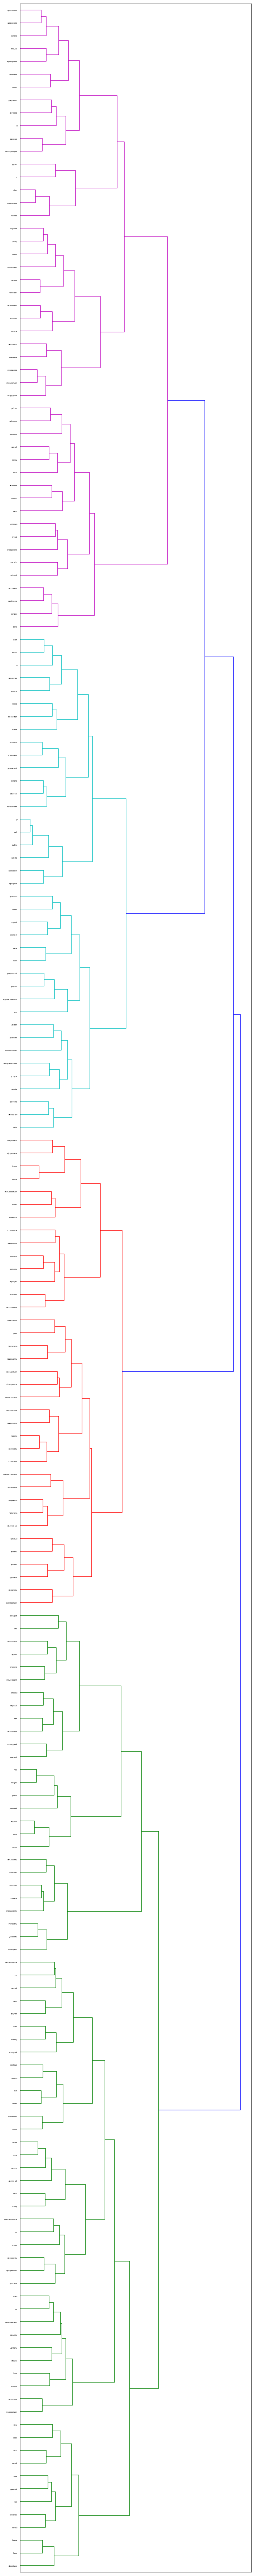

In [79]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


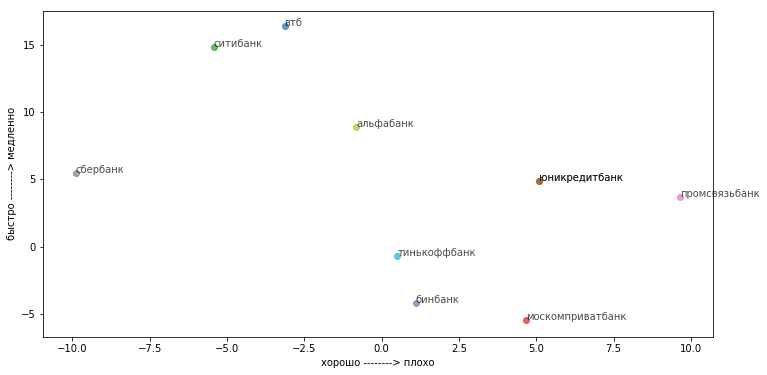

In [85]:
x2, x1 = ['хорошо','плохо']
y2, y1 = ['быстро','медленно']
x_label = "%s --------> %s" % (x2, x1)
y_label = "%s --------> %s" % (y2, y1)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
banks = "втб юникредитбанк ситибанк москомприватбанк бинбанк юникредитбанк промсвязьбанк сбербанк альфабанк тинькоффбанк".split()
for bank in banks:
    x = model[bank].dot(model[x2] - model[x1])
    y = model[bank].dot(model[y2] - model[y1])
    ax.scatter(x, y, alpha=0.7)
    ax.text(x, y, bank, alpha=0.7)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.show()

люди считают что сбербанк это не плохо)

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [ ]:
# пример построения графа 

import igraph as ig
g = ig.Graph(directed=True)
for word in model.wv.vocab.keys():
    g.add_vertex(word)
    
    
    
for word in model.wv.vocab.keys() :
    node = g.vs.select(name = word).indices[0]
    similar_words = model.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)